## Inspect data

In [1]:
import json
from constants import TEXTS_DIR, PERSPECTIVE_API_RESPONSE_DIR

In [2]:
# Print sample text
sample_text_file = TEXTS_DIR / '0000108-c17b018a21dba0c9c84e5f6dca782cbd.txt'
sample_text_file.read_text()

'WASHINGTON (Reuters) - Telecommunications giant AT&T struck back on Wednesday at Sen. Herb Kohl, chair of a congressional antitrust panel, saying the lawmaker’s concerns about a lack of competition in the wireless industry were unfounded.\n\nKohl wrote to the Justice Department’s top antitrust regulator Christine Varney and Federal Communications Commission Chairman Julius Genachowski on Monday to reiterate concerns over texting prices, large carriers failing to cooperate with smaller carriers to resolve roaming disputes, disputes over spectrum and deals that give one or another carrier exclusive access to popular phones like the iPhone.\n\nAT&T argued that cell service had become progressively cheaper, with revenue per minute falling 89 percent since 1994.\n\n“U.S. wireless prices are much lower than in any other major industrialized country,” wrote James Cicconi, an AT&T senior executive vice president.\n\nCicconi argued that texting prices had fallen because of package deals, “drop

In [3]:
# Print sample response
sample_response_file = PERSPECTIVE_API_RESPONSE_DIR / '0000108-c17b018a21dba0c9c84e5f6dca782cbd.txt.json'

with sample_response_file.open() as f:
    sample_response = json.load(f)

sample_response

{'attributeScores': {'TOXICITY': {'spanScores': [{'begin': 0,
     'end': 2504,
     'score': {'value': 0.09871901, 'type': 'PROBABILITY'}}],
   'summaryScore': {'value': 0.09871901, 'type': 'PROBABILITY'}}},
 'languages': ['en'],
 'detectedLanguages': ['en']}

## Load into pandas

In [4]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import os
from constants import TOXICITY_SCORES_PICKLE

In [25]:
# Load Perspective API responses into dataframe

if not TOXICITY_SCORES_PICKLE.exists():
    rows = []

    for toxicity_file in PERSPECTIVE_API_RESPONSE_DIR.iterdir():
        if toxicity_file.suffix != '.json':
            continue

        toxicity_json = json.load(toxicity_file.open())
        toxicity_score = toxicity_json['attributeScores']['TOXICITY']['summaryScore']['value']

        text_filename = toxicity_file.name[:-5]
        assert text_filename.endswith('.txt')
        text_file = TEXTS_DIR / text_filename
        text = text_file.read_text()

        rows.append([text_filename, toxicity_score, text])

    df = pd.DataFrame(rows, columns=['filename', 'toxicity_score', 'text'])
    
    # Save a pickle for later
    df.to_pickle(TOXICITY_SCORES_PICKLE)
else:
    df = pd.read_pickle(TOXICITY_SCORES_PICKLE)

## Basic Analysis

In [26]:
# Data sorted by toxicity
df.sort_values(by=['toxicity_score'], ascending=False)

,filename,toxicity_score,text
131494,0490610-99f159c7a4b9868addbda9199cb17cdf.txt,0.990670,"FUCK /u/SPEZ , YOU FUCKING WORTHLESS CUCK FUCK..."
90904,0672031-2e34d061fc3c5e59d8730115bf3ef6b5.txt,0.947267,From fucking fbombingmom:\n\nI’d like to submi...
91076,0015608-1d7d2627e8be693ee345f6c5a4a79786.txt,0.946782,"'No, Really, Fuck Every One Of You'\n\nWASHING..."
58110,0278354-b3bdb61b43e24d62f7a1cbc88c41598c.txt,0.946288,Air America's Randi Rhodes said suspended for ...
31434,0005265-30f6c1242730bf4f9ef4ac0a65b785a7.txt,0.927032,"Jang Moonbok, the “fuckboy” from ‘God Of Music..."
19932,0764561-709f4ecb3166356dd57ecac7e266f858.txt,0.921134,You probably heard about the deranged sorority...
61286,0027620-b27d673c1fb056b708559632f7f0ca9b.txt,0.907830,Evan Brunell is a baseball writer and the pres...
47382,0092718-0b244361bde2506bb51478de5777712b.txt,0.899773,\n\nDoes your vagina have a brand?\n\nLet your...
5060,0159720-0dffc558696a5a22303ef62e0faa1f83.txt,0.899565,feminismisimportantlove:\n\ndanny-dice:\n\nfem...
102015,0955335-decce7189212838edb4fae8130e9977e.txt,0.899428,Login to vote this up!\n\nSo my brother just l...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa650ec240>]],
      dtype=object)

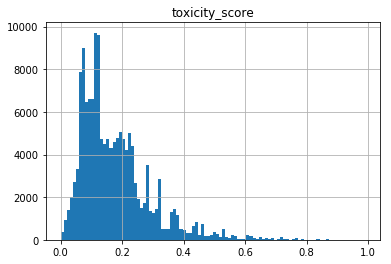

In [7]:
# Histogram of toxicity scores
# TODO: norm
df.hist(column='toxicity_score', bins=100)

In [8]:
df['text'][0]

'PC leadership hopefuls bring little to race\n\nChow as NDP leader changes the equation\n\nTORONTO November 1st, 2014 – In a random sampling of public opinion taken by the Forum Poll™ among 1104 Ontario voters, vote shares for the Progressive Conservative party are lower when actual leadership contenders are named than when no leader is named, but when Olivia Chow is proposed as leader of the Ontario New Democrats, the balance of probabilities changes considerably.\n\nLiberals with 5 point lead in generic horserace\n\nIn the generic horserace, where no leaders are named, results are very similar to the recent election, and 4-in-10 will vote Liberal if a provincial election were held today (40%), while just more than a third will vote PC (35%). In this scenario, the NDP take a fifth of the vote (19%), and the Greens (4%) and other parties take few (2%).\n\n\n\n\n\nTwo seat majority seen for Liberals\n\nIf these results were projected up to seats in a 107 seat Legislature, the Liberals w

# Analyze with scikit

In [10]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text"])

feature_names = vectorizer.get_feature_names()

In [ ]:
df_idf = pd.DataFrame(vectorizer.idf_, index=feature_names, columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'], ascending=False)

In [29]:
document_vector = X[90904]
df_tfidf = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False)

,tfidf
fucking,0.745171
fuckin,0.372744
hate,0.214885
bitches,0.171338
fuck,0.157150
you,0.119335
the,0.084871
your,0.081205
dick,0.079010
and,0.075057


## Analyze with NLTK

In [ ]:
from collections import Counter
import nltk
from nltk import ngrams

In [43]:
all_texts = list(sorted_df['text'])

In [44]:
# Calculate n-gram frequencies
N = 2
limit = 1000

freqs = Counter()
for text in all_texts[:limit]:
    freqs += Counter(ngrams(text.split(' '), n=N))

In [45]:
# Show most common n-grams
freqs.most_common(100)

[(('of', 'the'), 2650),
 (('in', 'the'), 2356),
 (('to', 'the'), 1392),
 (('to', 'be'), 1253),
 (('on', 'the'), 1226),
 (('in', 'a'), 875),
 (('I', 'was'), 810),
 (('is', 'a'), 781),
 (('for', 'the'), 762),
 (('and', 'the'), 728),
 (('at', 'the'), 716),
 (('of', 'a'), 682),
 (('with', 'a'), 674),
 (('going', 'to'), 664),
 (('with', 'the'), 649),
 (('out', 'of'), 628),
 (('want', 'to'), 613),
 (('and', 'I'), 557),
 (('from', 'the'), 538),
 (('as', 'a'), 532),
 (('it', 'was'), 526),
 (('for', 'a'), 525),
 (('is', 'the'), 495),
 (('to', 'get'), 484),
 (('have', 'to'), 483),
 (('one', 'of'), 472),
 (('was', 'a'), 468),
 (('to', 'a'), 466),
 (('that', 'the'), 432),
 (('to', 'do'), 420),
 (('I', 'have'), 399),
 (('that', 'I'), 397),
 (('if', 'you'), 394),
 (('have', 'a'), 390),
 (('by', 'the'), 388),
 (('about', 'the'), 383),
 (('all', 'the'), 368),
 (('and', 'a'), 368),
 (('trying', 'to'), 365),
 (('like', 'a'), 362),
 (('he', 'was'), 360),
 (('of', 'my'), 353),
 (('a', 'lot'), 352),
 (('of

In [ ]:
# TODO: show n-grams that are *unique* to high-toxicity text
# TODO: maybe use something like tf-idf?